In [1]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(gridExtra)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [ ]:
# Code to use in all-humans
setwd("../../../Data/Fernandez et al. (2019)")
list.files()
getwd()

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)

# Read in data
P1 <- Read10X(data.dir = "P1")
P2 <- Read10X(data.dir = "P2")
P3 <- Read10X(data.dir = "P3")
P4 <- Read10X(data.dir = "P4")
P5 <- Read10X(data.dir = "P5")
P6 <- Read10X(data.dir = "P6")


# Create Seurat objects
P1 <- CreateSeuratObject(P1, project="Fernandez et al. (2019), P1")
P2 <- CreateSeuratObject(P2, project="Fernandez et al. (2019), P2")
P3 <- CreateSeuratObject(P3, project="Fernandez et al. (2019), P3")
P4 <- CreateSeuratObject(P4, project="Fernandez et al. (2019), P4")
P5 <- CreateSeuratObject(P5, project="Fernandez et al. (2019), P5")
P6 <- CreateSeuratObject(P6, project="Fernandez et al. (2019), P6")

# Merge
samples <- merge(P1, y=list(P2, P3, P4, P5, P6))

# Merge layers
samples[["RNA"]] <- JoinLayers(samples[["RNA"]])

# Save
samples[["Species"]] <- "Human"
saveRDS(samples, file = "Fernandez_raw.rds")

[1] "integrated_Fernandez.rds" "P1"                      
[3] "P2"                       "P3"                      
[5] "P4"                       "P5"                      
[7] "P6"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Fernandez et al. (2019)"

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [5]:
# Set wd
setwd("../../../Data/Fernandez et al. (2019)")
list.files()
getwd()

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)

# Read in data
P1 <- Read10X(data.dir = "P1")
P2 <- Read10X(data.dir = "P2")
P3 <- Read10X(data.dir = "P3")
P4 <- Read10X(data.dir = "P4")
P5 <- Read10X(data.dir = "P5")
P6 <- Read10X(data.dir = "P6")


# Create Seurat objects
P1 <- CreateSeuratObject(P1, project="P1")
P2 <- CreateSeuratObject(P2, project="P2")
P3 <- CreateSeuratObject(P3, project="P3")
P4 <- CreateSeuratObject(P4, project="P4")
P5 <- CreateSeuratObject(P5, project="P5")
P6 <- CreateSeuratObject(P6, project="P6")


# Merge the Seurat objects
samples <- merge(P1, y=list(P2, P3, P4, P5, P6),
                    add.cell.ids = c("P1", "P2", "P3", "P4", "P5", "P6"),
                    project="All plaques merged")

# Merge layers
samples[["RNA"]] <- JoinLayers(samples[["RNA"]])

[1] "P1" "P2" "P3" "P4" "P5" "P6"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Fernandez et al. (2019)"

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [6]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:significant_pcs, verbose=FALSE)

    # Integrate # Replaced CCA by Harmony
    data <- IntegrateLayers(object = data, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca", k.weight = k.weights)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", verbose=FALSE)

    return(data)
}

data <- pre_process(samples, pattern= "MT", percents.mt = 10)

Normalizing layer: counts.P1

Normalizing layer: counts.P2

Normalizing layer: counts.P3

Normalizing layer: counts.P4

Normalizing layer: counts.P5

Normalizing layer: counts.P6

Finding variable features for layer counts.P1

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.0314"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.30103"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  9.0363e-15"
Finding variable features for layer counts.P2

Finding variable features for layer counts.P3

Finding variable features for layer counts.P4

Finding variable features for layer counts.P5

Finding variable features for layer counts.P6

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.0899"
Warning message in simpleLoess(y, x, w, sp

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5435
Number of edges: 214299

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8646
Number of communities: 14
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5435
Number of edges: 214299

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8499
Number of communities: 15
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5435
Number of edges: 214299

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8375
Number of communities: 16
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5435
Number of edges: 214299

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8265
Number of communities: 18
Elapsed time: 0 seconds
Modularity Optim

In [7]:
# Save
saveRDS(data, file = "integrated_Fernandez.rds")

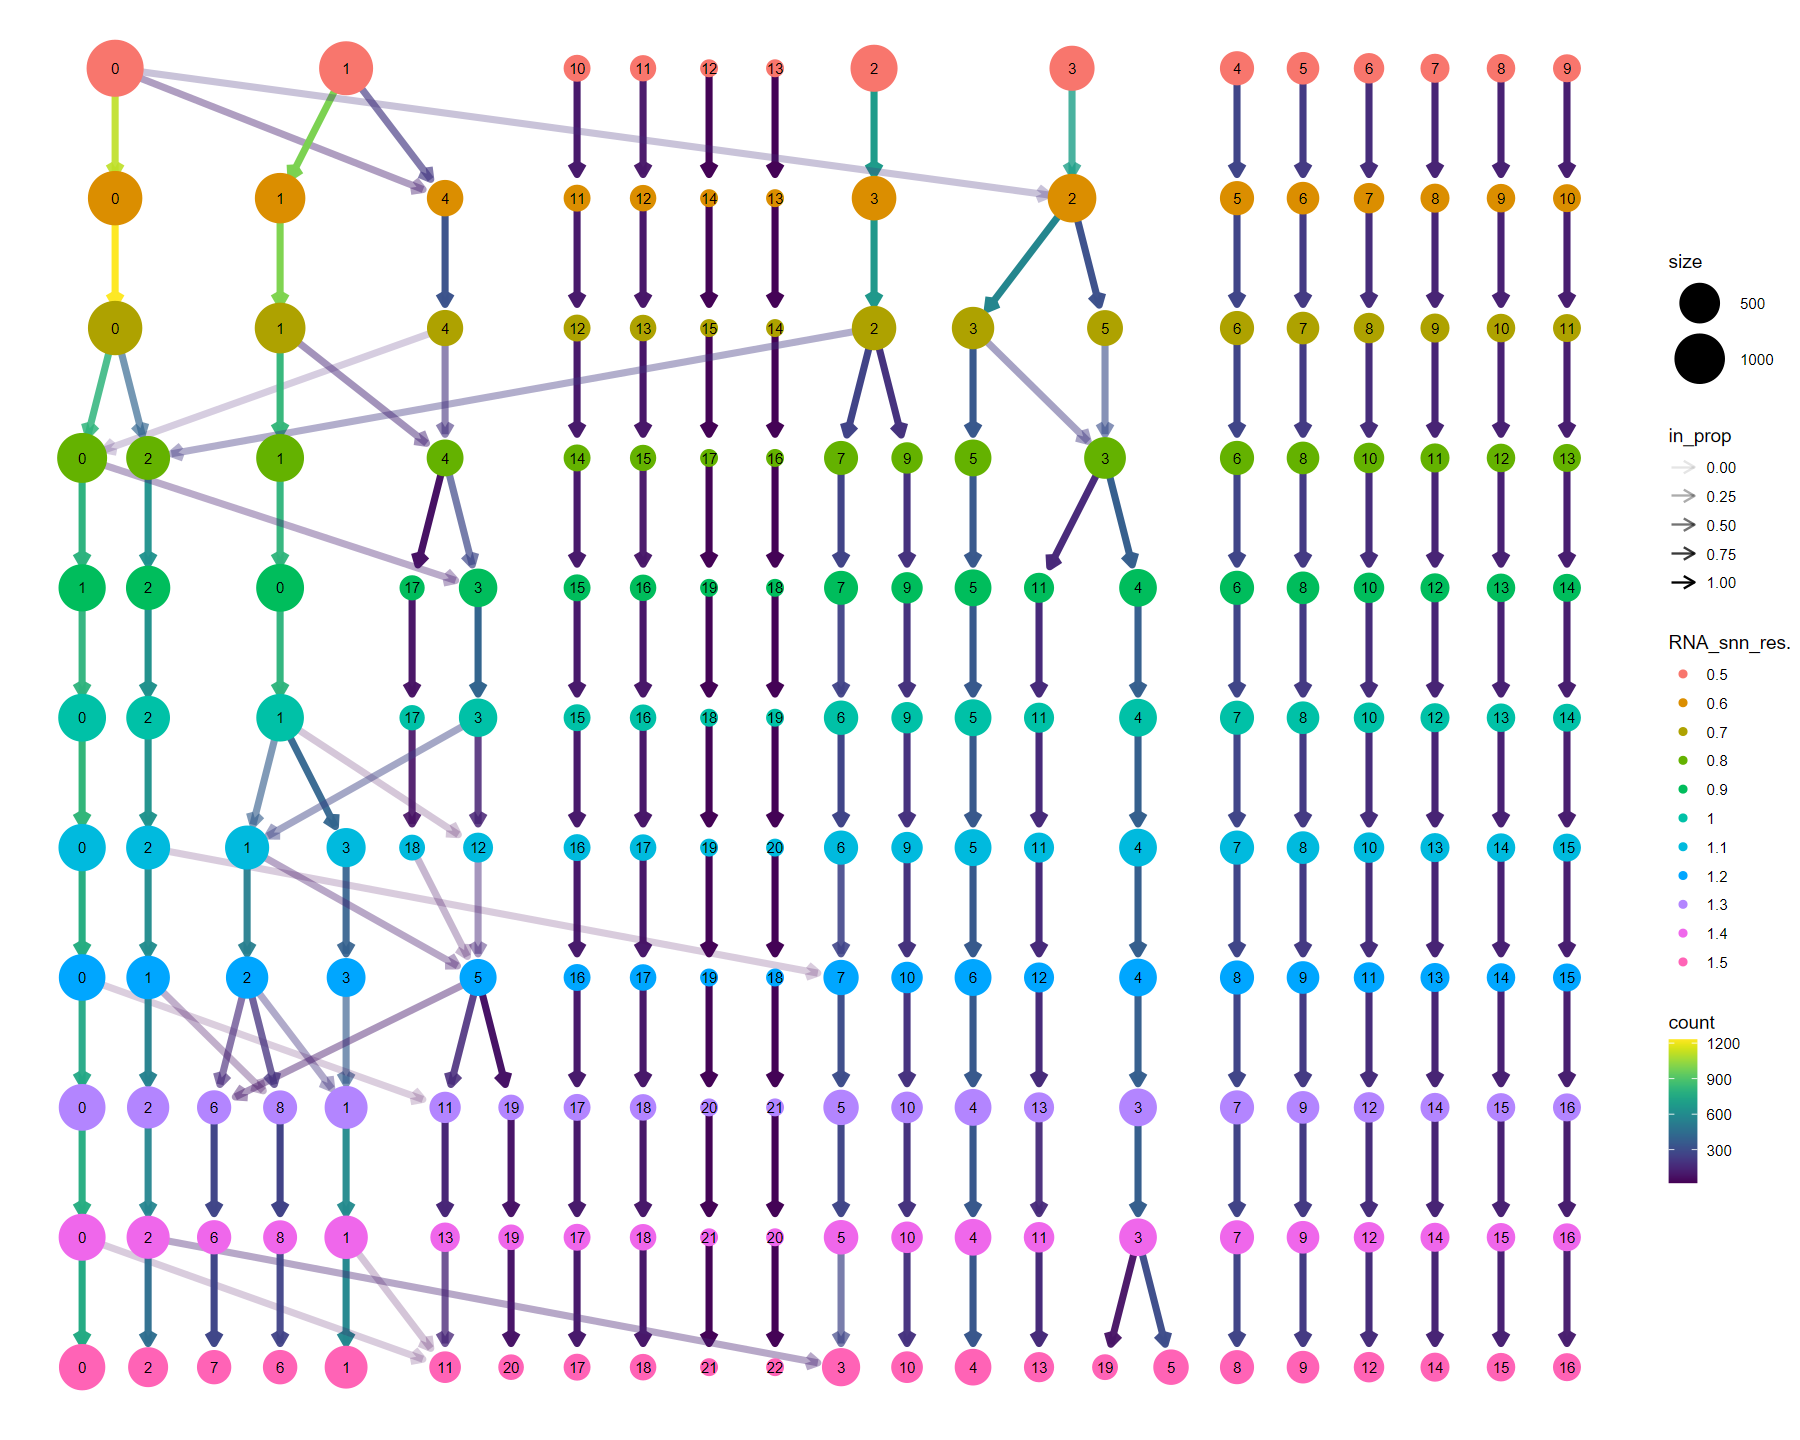

In [8]:
# This cell is meant to analyze the different resolutions and see which one is the best
# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

In [10]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.0.7`

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Adipocytes,0,0,2,0,0,0,0,4,0,0,24,0,0,0,0,0
Astrocytes,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0
B-cells,0,0,1,0,0,0,0,0,0,128,0,0,79,2,12,0
CD4+ T-cells,27,320,126,0,74,0,0,0,0,0,0,0,0,3,0,0
CD8+ T-cells,1191,688,485,27,251,179,0,0,0,9,2,2,12,65,0,1
Chondrocytes,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0
DC,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,0
Endothelial cells,0,3,5,0,0,0,0,0,0,0,98,0,0,0,0,0
Erythrocytes,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0
Fibroblasts,0,0,1,0,0,0,1,195,0,0,1,0,0,1,0,0


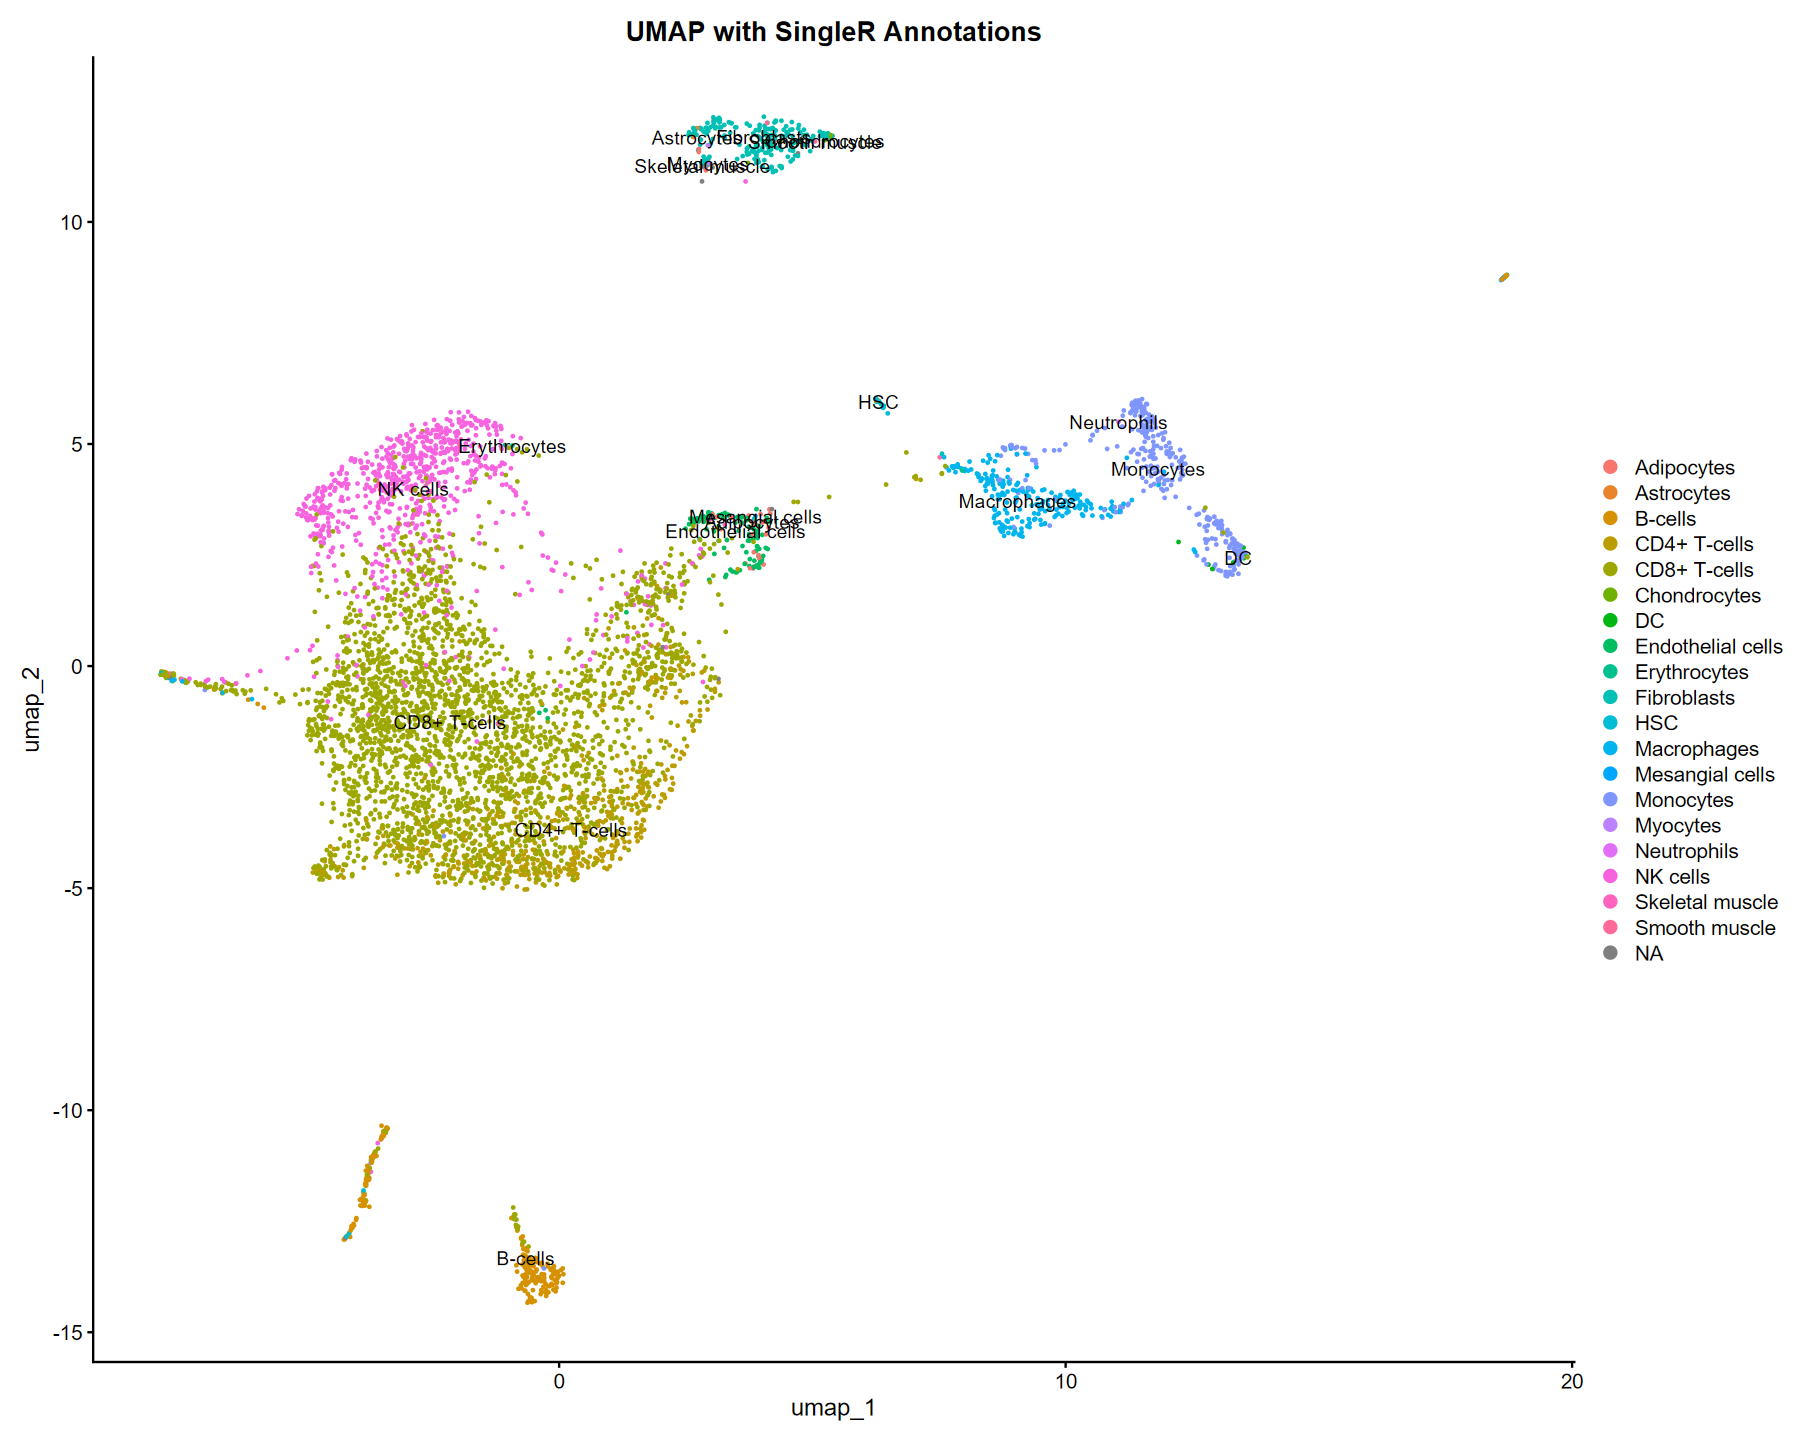

In [11]:
# Annotation code block

# Get reference atlas
hpca.se <- celldex::BlueprintEncodeData()
data.sce <- as.SingleCellExperiment(data)

# Predict
pred.hpca <- SingleR(test = data.sce, ref = hpca.se, assay.type.test=1,
    labels = hpca.se$label.main)

# View annotations
cluster_table <- cbind(table(pred.hpca$pruned.labels, data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.hpca$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")